# Customer Churn Machine Learning Model Development 

Customer churn refers to the rate at which customers stop using or doing business with a company. It is a measure of customer attrition or loss. Mitigating customer churn is important for the success metrics of an application because retaining existing customers is more cost-effective than acquiring new customers. By reducing churn, a company can maintain a stable customer base, increase customer lifetime value, improve revenue and profitability, enhance brand loyalty, and foster positive word-of-mouth referrals. Ultimately, mitigating customer churn contributes to the overall growth and success of the application.



In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import torch
from torch import nn
from skorch import NeuralNetClassifier
import math


import warnings
warnings.filterwarnings('ignore')

In [13]:
data = pd.read_csv('../data_sets/Churn_Modelling.csv').dropna()
data

,CustomerId,CredRate,Geography,Gender,Age,Tenure,Balance,Prod Number,HasCrCard,ActMem,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39.0,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35.0,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36.0,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42.0,3,75075.31,2,1,0,92888.52,1


# Data Cleaning 

In [14]:
# Rename columns
data = data.rename(columns={
    'CredRate': 'CreditScore',
    'ActMem': 'IsActiveMember',
    'Prod Number': 'NumOfProducts',
    'Exited': 'Churn'
})

# Drop CustomerId column
data.drop(labels=['CustomerId'], axis=1, inplace=True)

# Move Churn column to the right
column_churn = data['Churn']
data.drop(labels=['Churn'], axis=1, inplace=True)
data.insert(len(data.columns), 'Churn', column_churn.values)

# Convert data types to category
data["Geography"] = data["Geography"].astype('category')
data["Gender"] = data["Gender"].astype('category')
data["HasCrCard"] = data["HasCrCard"].astype('category')
data["Churn"] = data["Churn"].astype('category')
data["IsActiveMember"] = data["IsActiveMember"].astype('category')

# Check column names and data types
data.columns
data.dtypes


CreditScore           int64
Geography          category
Gender             category
Age                 float64
Tenure                int64
Balance             float64
NumOfProducts         int64
HasCrCard          category
IsActiveMember     category
EstimatedSalary     float64
Churn              category
dtype: object

# Exploratory Data Analysis

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

class DataAnalyzer:
    def __init__(self, data):
        self.data = data
        
    def univariate_analysis(self):
        f, axes = plt.subplots(ncols=3, figsize=(15, 6))
        
        sns.distplot(self.data['EstimatedSalary'], kde=True, color="blue", ax=axes[0]).set_title('EstimatedSalary')
        axes[0].set_ylabel('No of Customers')
        
        sns.distplot(self.data['Age'], kde=True, color="blue", ax=axes[1]).set_title('Age')
        axes[1].set_ylabel('No of Customers')
        
        sns.distplot(self.data['Balance'], kde=True, color="red", ax=axes[2]).set_title('Balance')
        axes[2].set_ylabel('No of Customers')
        
        plt.show()
        
    def bivariate_analysis_gender_churn(self):
        plt.figure(figsize=(15, 4))
        
        p = sns.countplot(y="Gender", hue='Churn', data=self.data, palette="bright")
        legend = p.get_legend()
        legend_txt = legend.texts
        legend_txt[0].set_text("No Churn")
        legend_txt[1].set_text("Churn")
        
        p.set_title('Customer Churn Distribution by Gender')
        plt.show()
    
    def bivariate_analysis_geography_churn(self):
        plt.figure(figsize=(15, 4))
        
        p = sns.countplot(x='Geography', hue='Churn', data=self.data, palette="bright")
        legend = p.get_legend()
        legend_txt = legend.texts
        legend_txt[0].set_text("No Churn")
        legend_txt[1].set_text("Churn")
        
        p.set_title('Customer Geography Distribution')
        plt.show()
    
    def bivariate_analysis_numofproducts_churn(self):
        plt.figure(figsize=(15, 4))
        
        p = sns.countplot(x='NumOfProducts', hue='Churn', data=self.data, palette="bright")
        legend = p.get_legend()
        legend_txt = legend.texts
        legend_txt[0].set_text("No Churn")
        legend_txt[1].set_text("Churn")
        
        p.set_title('Customer Distribution by Product')
        plt.show()
    
    def bivariate_analysis_age_churn(self):
        plt.figure(figsize=(15, 4))
        
        ax = sns.kdeplot(data.loc[data['Churn'] == 0, 'Age'], color=sns.color_palette("bright")[0], 
                         shade=True, label='no churn', linestyle='--')
        ax = sns.kdeplot(data.loc[data['Churn'] == 1, 'Age'], color=sns.color_palette("bright")[1], 
                         shade=True, label='churn')
        ax.set(xlabel='Customer Age', ylabel='Frequency')
        plt.title('Customer Age - churn vs no churn')
        plt.legend()
        plt.show()
    
    def bivariate_analysis_balance_churn(self):
        plt.figure(figsize=(15, 4))
        
        ax = sns.kdeplot(data.loc[data['Churn'] == 0, 'Balance'], color=sns.color_palette("bright")[0], 
                         shade=True, label='no churn', linestyle='--')
        ax = sns.kdeplot(data.loc[data['Churn'] == 1, 'Balance'], color=sns.color_palette("bright")[1], 
                         shade=True, label='churn')
        ax.set(xlabel='Customer Balance', ylabel='Frequency')
        plt.title('Customer Balance - churn vs no churn')
        plt.legend()
        plt.show()
    
    def bivariate_analysis_creditscore_churn(self):
        plt.figure(figsize=(15, 4))
        
        ax = sns.kdeplot(data.loc[data['Churn'] == 0, 'CreditScore'], color=sns.color_palette("bright")[0],
                         shade=True, label='no churn', linestyle='--')
        ax = sns.kdeplot(data.loc[data['Churn'] == 1, 'CreditScore'], color=sns.color_palette("bright")[1],
                         shade=True, label='churn')
        ax.set(xlabel='CreditScore', ylabel='Frequency')
        plt.title('Customer CreditScore - churn vs no churn')
        plt.legend()
        plt.show()
    
    def bivariate_analysis_balance_numofproducts_churn(self):
        plt.figure(figsize=(16, 4))
        
        p = sns.barplot(x='NumOfProducts', y='Balance', hue='Churn', data=self.data, palette="bright")
        p.legend(loc='upper right')
        legend = p.get_legend()
        legend_txt = legend.texts
        legend_txt[0].set_text("No Churn")
        legend_txt[1].set_text("Churn")
        
        p.set_title('Number of Product VS Balance')
        plt.show()


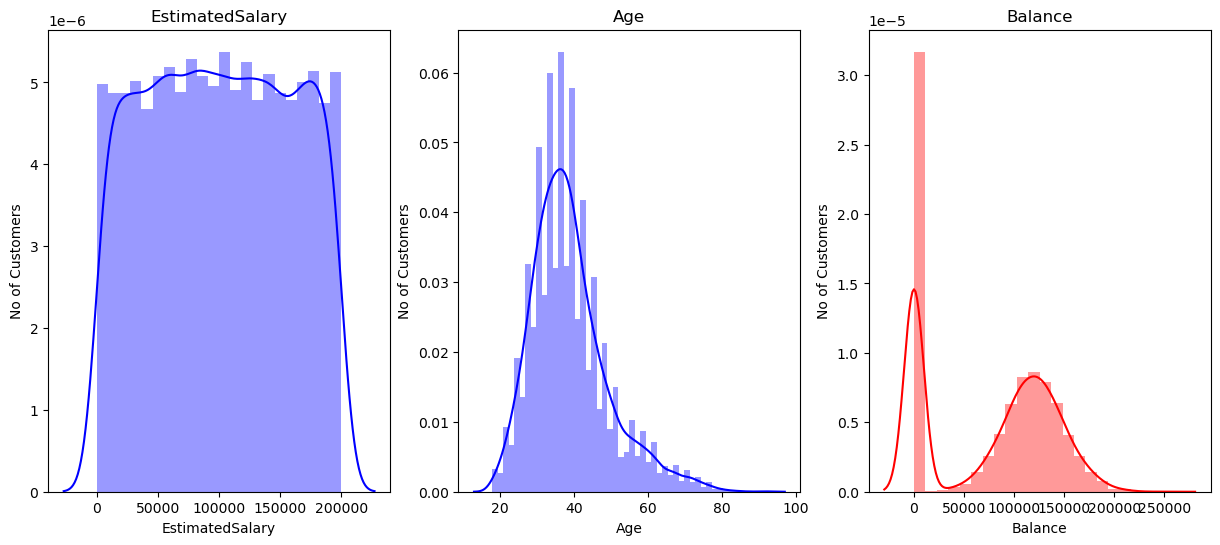

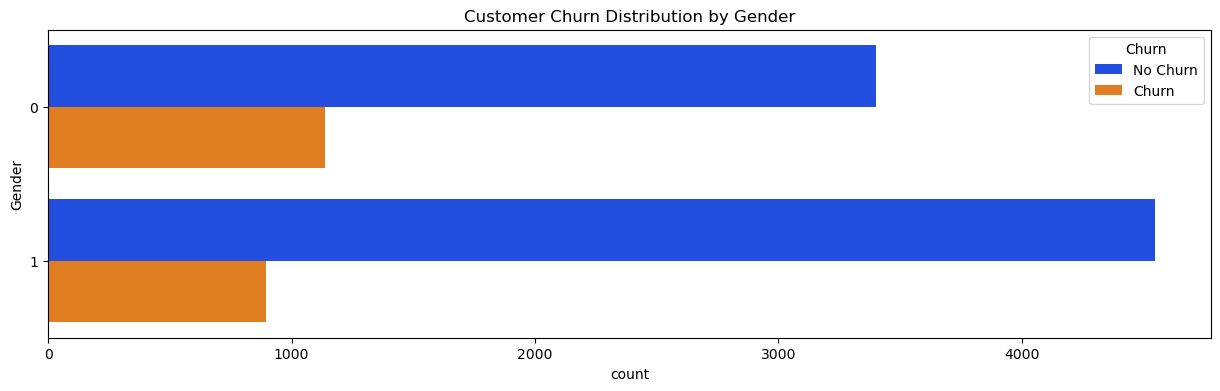

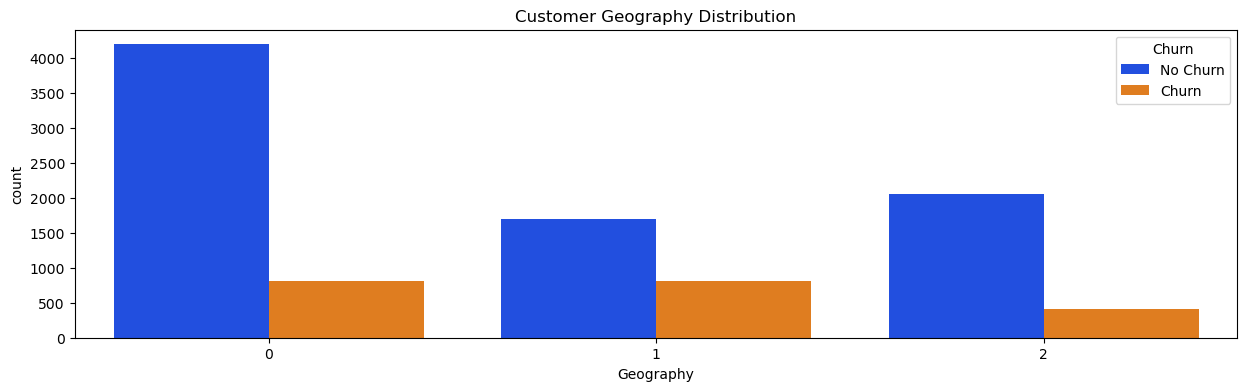

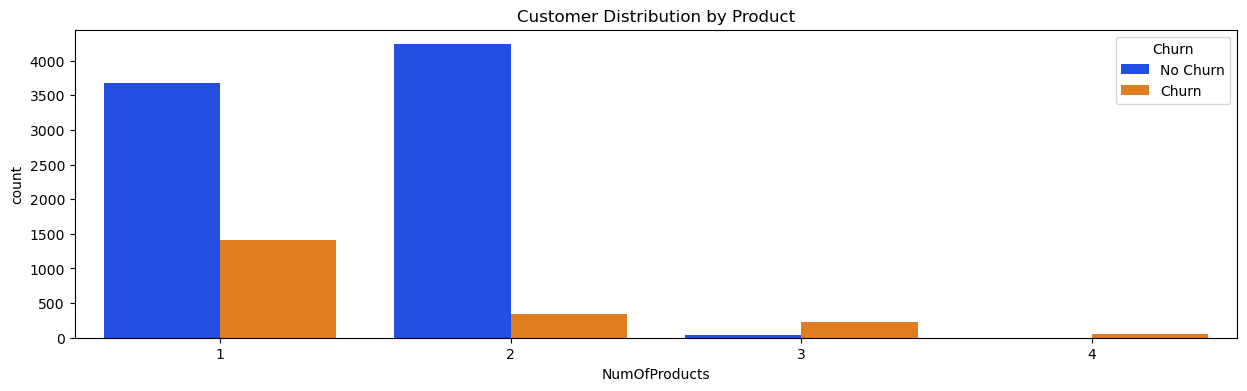

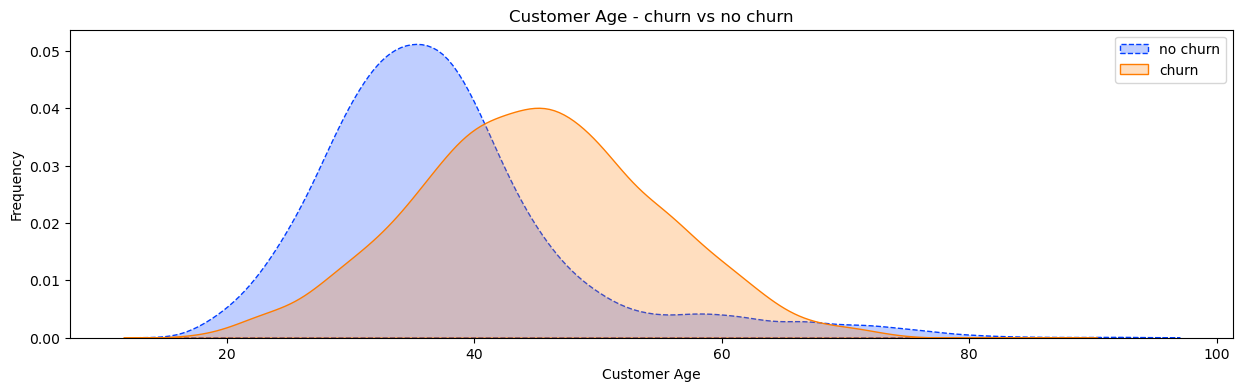

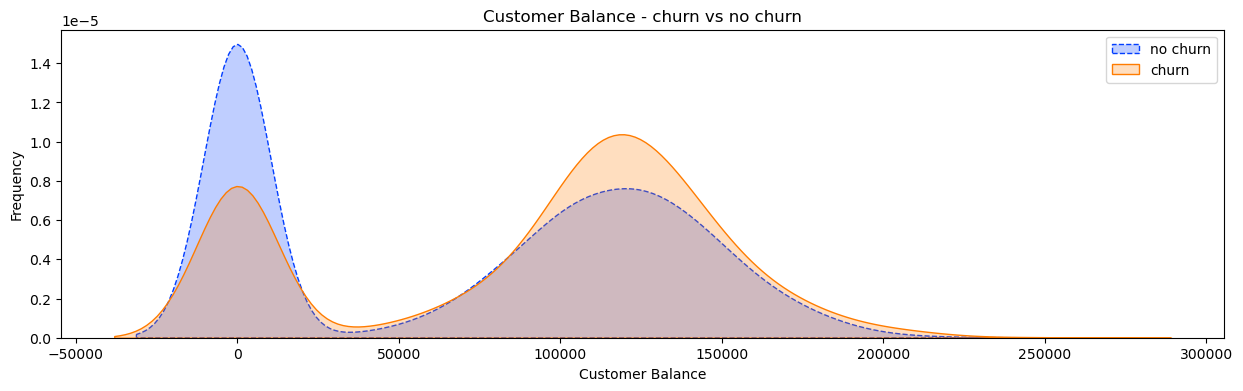

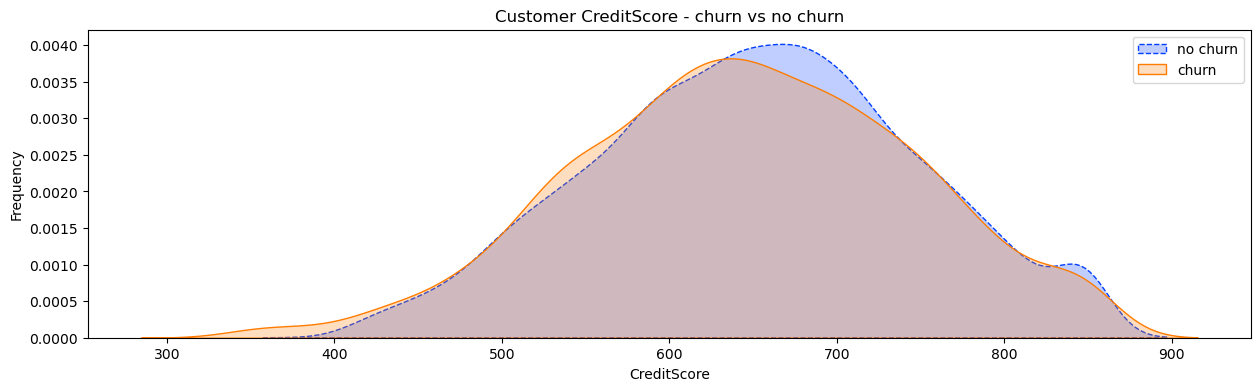

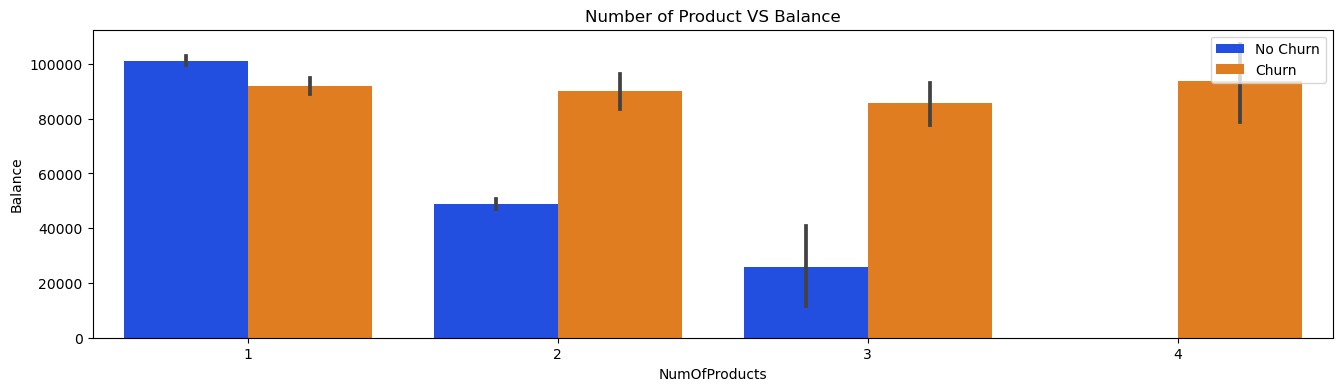

In [22]:
data_analyzer = DataAnalyzer(data)
data_analyzer.univariate_analysis()
data_analyzer.bivariate_analysis_gender_churn()
data_analyzer.bivariate_analysis_geography_churn()
data_analyzer.bivariate_analysis_numofproducts_churn()
data_analyzer.bivariate_analysis_age_churn()
data_analyzer.bivariate_analysis_balance_churn()
data_analyzer.bivariate_analysis_creditscore_churn()
data_analyzer.bivariate_analysis_balance_numofproducts_churn()


,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
CreditScore,1.000000,-0.004527,0.000996,0.006342,0.012860,-0.001044
Age,-0.004527,1.000000,-0.009615,0.028017,-0.030747,-0.007227
Tenure,0.000996,-0.009615,1.000000,-0.011429,0.013030,0.008114
Balance,0.006342,0.028017,-0.011429,1.000000,-0.304151,0.012623
NumOfProducts,0.012860,-0.030747,0.013030,-0.304151,1.000000,0.014379
EstimatedSalary,-0.001044,-0.007227,0.008114,0.012623,0.014379,1.000000


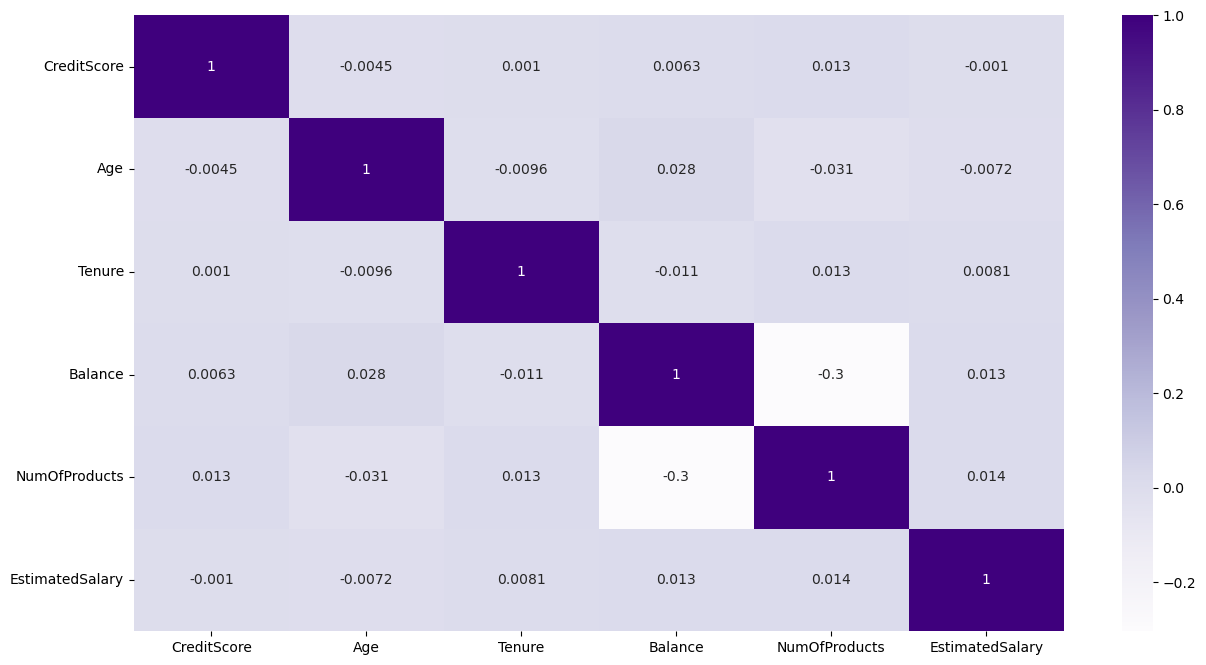

In [9]:
# Number of customers who churned
data['Churn'].value_counts()

# Percentage of customers who churned
data['Churn'].value_counts(normalize=True) * 100

# Percentage of customers that have a credit card
data['HasCrCard'].value_counts(normalize=True) * 100

# Statistical overview of the data
data.describe()

# Mean attributes of customers who churned compared to those who did not churn
summary_churn = data.groupby('Churn')
summary_churn.mean()

# Median attributes of customers who churned compared to those who did not churn
summary_churn.median()

# Correlation plot
corr = data.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, cmap='Purples')
corr


# Feature Engineering

In [10]:

def engineer_features(data):
    # Create a new feature 'CreditScoreScaled' by scaling the 'CreditScore' column
    data['CreditScoreScaled'] = data['CreditScore'] / 850.0
    
    # Create a new feature 'AgeGroup' based on age ranges
    bins = [18, 30, 40, 50, 60, 70, 120]
    labels = ['18-30', '30-40', '40-50', '50-60', '60-70', '70+']
    data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)
    
    # Create a new feature 'BalanceRange' based on balance ranges
    bins = [-float('inf'), 0, 50000, 100000, float('inf')]
    labels = ['Negative', 'Low', 'Medium', 'High']
    data['BalanceRange'] = pd.cut(data['Balance'], bins=bins, labels=labels, right=False)
    
    # Create a new feature 'CreditRatio' by dividing 'CreditScore' by 'NumOfProducts'
    data['CreditRatio'] = data['CreditScore'] / data['NumOfProducts']
    
    # Create a new feature 'EstimatedSalaryLog' by taking the logarithm of 'EstimatedSalary'
    data['EstimatedSalaryLog'] = data['EstimatedSalary'].apply(lambda x: math.log(x) if x > 0 else 0)
    
    return data

engineer_features(data)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn,CreditScoreScaled,AgeGroup,BalanceRange,CreditRatio,EstimatedSalaryLog
0,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1,0.728235,40-50,Low,619.000000,11.526324
1,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0,0.715294,40-50,Medium,608.000000,11.631087
2,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1,0.590588,40-50,High,167.333333,11.643353
3,699,France,Female,39.0,1,0.00,2,0,0,93826.63,0,0.822353,30-40,Low,349.500000,11.449204
4,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0,1.000000,40-50,High,850.000000,11.278267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1,0,96270.64,0,0.907059,30-40,Low,385.500000,11.474919
9996,516,France,Male,35.0,10,57369.61,1,1,1,101699.77,0,0.607059,30-40,Medium,516.000000,11.529780
9997,709,France,Female,36.0,7,0.00,1,0,1,42085.58,1,0.834118,30-40,Low,709.000000,10.647460
9998,772,Germany,Male,42.0,3,75075.31,2,1,0,92888.52,1,0.908235,40-50,Medium,386.000000,11.439155


In [11]:
data.describe()


,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,CreditScoreScaled,CreditRatio,EstimatedSalaryLog
count,9986.000000,9986.000000,9986.000000,9986.000000,9986.000000,9986.000000,9986.000000,9986.000000,9986.000000
mean,650.564691,38.927799,5.010415,76539.635906,1.530142,100084.539598,0.765370,486.457299,11.208186
std,96.604678,10.491053,2.891614,62391.288935,0.581765,57511.969095,0.113653,183.594531,1.000654
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000,0.411765,94.000000,2.449279
25%,584.000000,32.000000,3.000000,0.000000,1.000000,50983.750000,0.687059,323.000000,10.839262
50%,652.000000,37.000000,5.000000,97262.675000,1.000000,100193.915000,0.767059,443.000000,11.514863
75%,717.750000,44.000000,7.000000,127653.825000,2.000000,149395.882500,0.844412,653.000000,11.914355
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000,1.000000,850.000000,12.206035


# Feature Selection


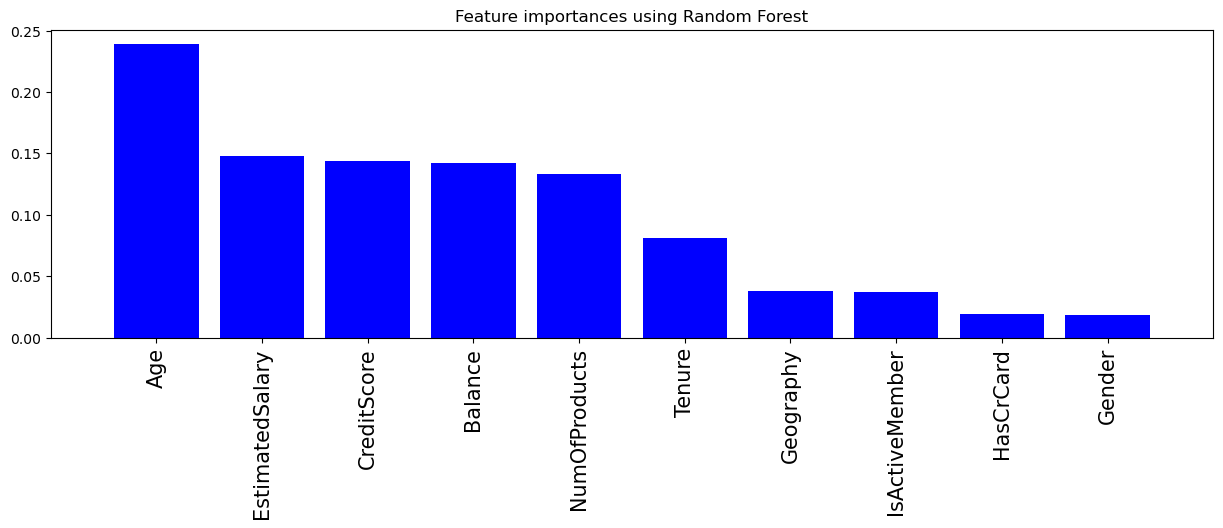

           Feature  Importance
0      CreditScore    0.144180
1        Geography    0.038247
2           Gender    0.018930
3              Age    0.238666
4           Tenure    0.081174
5          Balance    0.141895
6    NumOfProducts    0.133010
7        HasCrCard    0.018996
8   IsActiveMember    0.037200
9  EstimatedSalary    0.147701


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

class FeatureSelection:
    def __init__(self, data, target):
        self.data = data
        self.target = target
    
    def encode_categorical_variables(self):
        self.data["Geography"] = self.data["Geography"].astype('category').cat.codes
        self.data["Gender"] = self.data["Gender"].astype('category').cat.codes
        self.data["HasCrCard"] = self.data["HasCrCard"].astype('category').cat.codes
        self.data["Churn"] = self.data["Churn"].astype('category').cat.codes

    def split_data(self, test_size=0.15, random_state=123):
        X = self.data.drop(self.target, axis=1)
        y = self.data[self.target]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, 
                                                                                test_size=test_size, 
                                                                                random_state=random_state, 
                                                                                stratify=y)
    
    def fit_random_forest(self, n_estimators=500, random_state=1):
        self.forest = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        self.forest.fit(self.X_train, self.y_train)
    
    def plot_feature_importances(self):
        importances = self.forest.feature_importances_
        features = self.data.drop([self.target], axis=1).columns
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(15, 4))
        plt.title("Feature importances using Random Forest")
        plt.bar(range(self.X_train.shape[1]), importances[indices], color="blue", align="center")
        plt.xticks(range(self.X_train.shape[1]), features[indices], rotation='vertical', fontsize=15)
        plt.xlim([-1, self.X_train.shape[1]])
        plt.show()
    
    def display_feature_importances(self):
        importances = self.forest.feature_importances_
        features = self.data.drop([self.target], axis=1).columns
        feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
        print(feature_importance_df)


target = "Churn"

feature_selection = FeatureSelection(data, target)
feature_selection.encode_categorical_variables()
feature_selection.split_data()
feature_selection.fit_random_forest()
feature_selection.plot_feature_importances()
feature_selection.display_feature_importances()

# Machine Learning Modeling 

In [19]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class ChurnPredictionModel:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.top5_features = ['Age', 'EstimatedSalary', 'CreditScore', 'Balance', 'NumOfProducts']
        self.logistic_regression = None
        self.coef = None

        # Initialize the pipeline for data preprocessing
        self.pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('encoder', ColumnTransformer([
                ('encoder', OneHotEncoder())
            ], remainder='passthrough')),
            ('scaler', StandardScaler())
        ])

    def split_train_test(self, test_size=0.2, random_state=None):
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, 
                                                                                test_size=test_size,
                                                                                random_state=random_state)


    def fit(self):
        logReg = sm.Logit(self.y_train, self.X_train[self.top5_features])
        self.logistic_regression = logReg.fit()
        self.coef = self.logistic_regression.params

    def get_summary(self):
        return self.logistic_regression.summary()

    def calculate_churn_probability(self, age, estimated_salary, credit_score, balance, num_of_products):
        def y(coef, age, estimated_salary, credit_score, balance, num_of_products):
            return coef[0]*age + coef[1]*estimated_salary + coef[2]*credit_score + coef[3]*balance + coef[4]*num_of_products

        y1 = y(self.coef, age, estimated_salary, credit_score, balance, num_of_products)
        p = np.exp(y1) / (1 + np.exp(y1))
        return p

    def predict(self):
        return self.logistic_regression.predict(self.X_test[self.top5_features])

    def predict_proba(self):
        return self.logistic_regression.predict_proba(self.X_test[self.top5_features])

    def evaluate_accuracy(self):
        return self.logistic_regression(self.X_test[self.top5_features], self.y_test)

    def perform_cross_validation(self, cv=5):
        return cross_val_score(LogisticRegression(), self.X_train[self.top5_features], self.y_train, cv=cv)

    def perform_grid_search(self, param_grid, cv=5):
        grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=cv)
        grid_search.fit(self.X_train[self.top5_features], self.y_train)
        return grid_search.best_params_



In [20]:
# Assuming you have X and y as your input data
X = data.drop(columns=['Churn','Geography', 'Gender'])
y = data['Churn']

# Assuming you have X and y as your input data

# Create an instance of the ChurnPredictionModel class
model = ChurnPredictionModel(X, y)

# Split the data into train and test sets
model.split_train_test(test_size=0.2, random_state=42)

# Fit the logistic regression model
model.fit()

# Get the model summary
summary = model.get_summary()
print(summary)

# Calculate churn probability for a given customer
churn_probability = model.calculate_churn_probability(50, 100000, 600, 100000, 2)
print("Churn Probability:", churn_probability)

# Predict on the test data
y_pred = model.predict()
y_pred_proba = model.predict_proba

# Evaluate the accuracy of the model
accuracy = model.evaluate_accuracy
print("Accuracy:", accuracy)

# Perform cross-validation
cross_val_scores = model.perform_cross_validation(cv=5)
print("Cross-Validation Scores:", cross_val_scores)

# Perform grid search for hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}
best_params = model.perform_grid_search(param_grid, cv=5)
print("Best Parameters:", best_params)




Optimization terminated successfully.
         Current function value: 0.479055
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7988
Model:                          Logit   Df Residuals:                     7983
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2023   Pseudo R-squ.:                 0.05543
Time:                        11:01:15   Log-Likelihood:                -3826.7
converged:                       True   LL-Null:                       -4051.2
Covariance Type:            nonrobust   LLR p-value:                 6.848e-96
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Age                 0.0440      0.002     18.608      0.000       0.039       0.049
EstimatedSalar

##### Results Description 

The results indicate that the logistic regression model has successfully converged with a current function value of 0.479055 after 6 iterations. The model summary shows the coefficients, standard errors, z-scores, and p-values for each predictor variable. The p-value represents the statistical significance of each predictor variable in relation to the outcome variable. Lower p-values indicate stronger evidence against the null hypothesis. The pseudo R-squared value of 0.05543 indicates that the model explains approximately 5.5% of the variance in the response variable, suggesting the proportion of variability captured by the model. 

The Churn Probability value of 0.3158609322966589 represents the predicted probability of churn based on the model's coefficients. The Accuracy method returns the accuracy of the churn prediction model. The Cross-Validation Scores represent the accuracy scores obtained through cross-validation. The Best Parameters indicate that the optimal value for the regularization parameter C is 0.01.

# Model Evaluation 